**Kinship Detection Project**

Importing libraries

In [2]:
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt

Reading csv files

In [3]:
train_df = pd.read_csv("../input/recognizing-faces-in-the-wild/train_relationships.csv")
test_df = pd.read_csv("../input/recognizing-faces-in-the-wild/sample_submission.csv")

In [4]:
train_df.head(10)

,p1,p2
0,F0002/MID1,F0002/MID3
1,F0002/MID2,F0002/MID3
2,F0005/MID1,F0005/MID2
3,F0005/MID3,F0005/MID2
4,F0009/MID1,F0009/MID4
5,F0009/MID1,F0009/MID3
6,F0009/MID1,F0009/MID2
7,F0009/MID1,F0009/MID6
8,F0009/MID2,F0009/MID4
9,F0009/MID2,F0009/MID6


In [5]:
test_df.head(10)

,img_pair,is_related
0,face05508.jpg-face01210.jpg,0
1,face05750.jpg-face00898.jpg,0
2,face05820.jpg-face03938.jpg,0
3,face02104.jpg-face01172.jpg,0
4,face02428.jpg-face05611.jpg,0
5,face01219.jpg-face00274.jpg,0
6,face04262.jpg-face00555.jpg,0
7,face03697.jpg-face01892.jpg,0
8,face03524.jpg-face00319.jpg,0
9,face03410.jpg-face05368.jpg,0


Loading pre-trained FaceNet model

In [6]:
from keras.models import load_model

model_path = '../input/facenet-keras/facenet_keras.h5' #From 'https://github.com/nyoki-mtl/keras-facenet' 
model = load_model(model_path)

Using TensorFlow backend.
/opt/conda/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/opt/conda/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/opt/conda/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/opt/conda/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:519: FutureWarn

Pre-processing images

In [7]:
def prewhiten(x):
    if x.ndim == 4:
        axis = (1, 2, 3)
        size = x[0].size
    elif x.ndim == 3:
        axis = (0, 1, 2)
        size = x.size
    else:
        raise ValueError('Dimension should be 3 or 4')

    mean = np.mean(x, axis=axis, keepdims=True)
    std = np.std(x, axis=axis, keepdims=True)
    std_adj = np.maximum(std, 1.0/np.sqrt(size))
    y = (x - mean) / std_adj
    return y

def l2_normalize(x, axis=-1, epsilon=1e-10):
    output = x / np.sqrt(np.maximum(np.sum(np.square(x), axis=axis, keepdims=True), epsilon))
    return output

def load_and_align_images(filepaths, margin,image_size = 160):
    
    aligned_images = []
    for filepath in filepaths:
        img = imread(filepath)
        aligned = resize(img, (image_size, image_size), mode='reflect')
        aligned_images.append(aligned)
            
    return np.array(aligned_images)

Computing Image Embeddings

In [8]:
def calc_embs(filepaths, margin=10, batch_size=512):
    pd = []
    for start in tqdm(range(0, len(filepaths), batch_size)):
        aligned_images = prewhiten(load_and_align_images(filepaths[start:start+batch_size], margin))
        pd.append(model.predict_on_batch(aligned_images))
    embs = l2_normalize(np.concatenate(pd))

    return embs

Checking Distance between images of same person, and between person and family members

In [9]:
from scipy.spatial import distance

def calc_dist(img_name0, img_name1):
    return distance.euclidean(data[img_name0]['emb'], data[img_name1]['emb'])

def calc_dist_plot(img_name0, img_name1):
    print(calc_dist(img_name0, img_name1))
    plt.subplot(1, 2, 1)
    plt.imshow(imread(data[img_name0]['image_filepath']))
    plt.subplot(1, 2, 2)
    plt.imshow(imread(data[img_name1]['image_filepath']))

In [13]:
from tqdm import tqdm
from imageio import imread
from skimage.transform import resize

image_dir_basepath = '../input/recognizing-faces-in-the-wild/train/F0002/'
names = ['MID1', 'MID2', 'MID3']
image_size = 160

data = {}
for name in names:
    image_dirpath = image_dir_basepath + name
    image_filepaths = [os.path.join(image_dirpath, f) for f in os.listdir(image_dirpath)]
    embs = calc_embs(image_filepaths)
    for i in range(len(image_filepaths)):
        data['{}{}'.format(name, i)] = {'image_filepath' : image_filepaths[i],
                                        'emb' : embs[i]}

100%|██████████| 1/1 [00:00<00:00,  2.10it/s]


0.5935722589492798


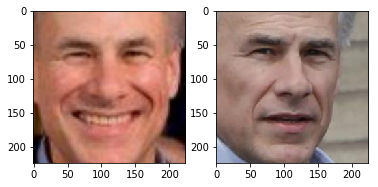

In [14]:
calc_dist_plot('MID10', 'MID11')

1.364683747291565


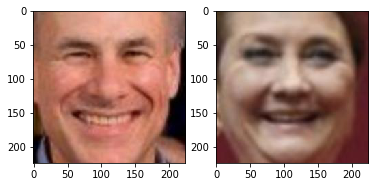

In [17]:
calc_dist_plot('MID10', 'MID20')

1.5191216468811035


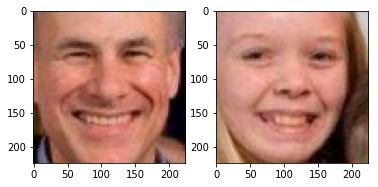

In [18]:
calc_dist_plot('MID10', 'MID30')

1.4458293914794922


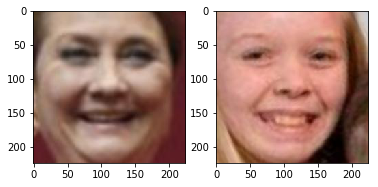

In [19]:
calc_dist_plot('MID20', 'MID30')

0.7522127032279968


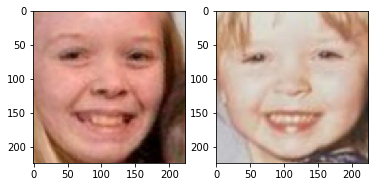

In [21]:
calc_dist_plot('MID30', 'MID33')

Plot

In [23]:
from sklearn.decomposition import PCA

X = []
for v in data.values():
    X.append(v['emb'])
pca = PCA(n_components=3).fit(X)

In [24]:
X_MID1 = []
X_MID2 = []
X_MID3 = []
for k, v in data.items():
    if 'MID1' in k:
        X_MID1.append(v['emb'])
    elif 'MID2' in k:
        X_MID2.append(v['emb'])
    elif 'MID3' in k:
        X_MID3.append(v['emb'])
        
Xd_MID1 = pca.transform(X_MID1)
Xd_MID2 = pca.transform(X_MID2)
Xd_MID3 = pca.transform(X_MID3)

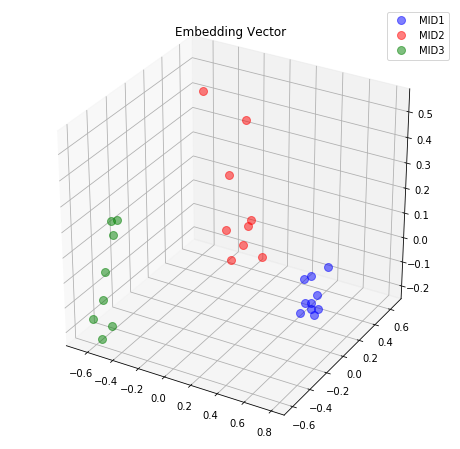

In [26]:
from mpl_toolkits.mplot3d import Axes3D
from mpl_toolkits.mplot3d import proj3d
import matplotlib.pyplot as plt
%matplotlib inline

fig = plt.figure(figsize=(8,8))
ax = fig.add_subplot(111, projection='3d')
plt.rcParams['legend.fontsize'] = 10   
ax.plot(Xd_MID1[:,0], Xd_MID1[:,1], Xd_MID1[:,2],
        'o', markersize=8, color='blue', alpha=0.5, label='MID1')
ax.plot(Xd_MID2[:,0], Xd_MID2[:,1], Xd_MID2[:,2],
        'o', markersize=8, color='red', alpha=0.5, label='MID2')
ax.plot(Xd_MID3[:,0], Xd_MID3[:,1], Xd_MID3[:,2],
        'o', markersize=8, color='green', alpha=0.5, label='MID3')

plt.title('Embedding Vector')
ax.legend(loc='upper right')

plt.show()